### TODO



### Imports

In [1]:
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_validate, cross_val_score

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, \
plot_confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score, make_scorer, log_loss, cohen_kappa_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif, chi2


# to determine the p-values with anova
from sklearn.feature_selection import f_classif

# to select features
from sklearn.feature_selection import SelectKBest, SelectFromModel, RFE # Recursive Feature Elimination

from feature_engine.selection import DropDuplicateFeatures, DropConstantFeatures, SmartCorrelatedSelection, SelectByShuffling, RecursiveFeatureElimination
from feature_engine.datetime import DatetimeFeatures
from feature_engine.outliers import Winsorizer
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

from ta import add_all_ta_features
from ta.utils import dropna

from xgboost import XGBClassifier

import seaborn as sns
import pandas_market_calendars as mcal
import warnings


from support._model_build_func import *

\\VSYS-P-GW01.cloud.vsys.ca\RDFolderRedirect$\fanjum_cwp\Desktop\Python\2x4\venv\Lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Reading Data from Excel daily_dataframe_main

In [2]:
# Takes 1 min 40 secs to run
Variables = pd.read_excel('daily_dataframe_main.xlsx', header=[0,1], sheet_name='Variables',index_col=0)
Response = pd.read_excel('daily_dataframe_main.xlsx',sheet_name= 'Response' ,index_col=0)

# Just using Unadjusted data for now
# Response = Response[['LB_Close','Close_ret','Close_Up_Down']]

### Imputing Values
<div style="color: DarkBlue; font-size:22px;" class="alert alert-block alert-warning"> 
<b>Check:</b> Backfilling and then frontfilling Variables DataFrame, and filling zeros with Median? - Check if it makes sense
</div>


In [3]:
Variables.fillna(method='bfill', inplace=True)
# Variables.fillna(method='ffill', inplace=True)
# Replacing 0 with Median Values
# Variables.replace(to_replace=0, method='bfill', inplace=True) 
# Variables.replace(to_replace=0, method=Variables.median(), inplace=True) 

### Date Engineering

In [4]:
warnings.filterwarnings("ignore")
Variables = add_date_features(Variables)


### Adding Technical Indicators

In [5]:
warnings.filterwarnings("ignore")

# TA_df = Variables[['LumberOHLCV LBHigh','LumberOHLCV LBLow','LumberOHLCV LBClose','LumberOHLCV LBVolume','LumberOHLCV LBopenInterest']]
TA_df = Variables.loc[:,('Lumber_OHLCV',)][['LB_High','LB_Low','LB_Close','LB_Volume','LB_openInterest']]

TA_df.columns = ['High','Low','Close','Volume','OpenInterest']
TA_df['Open'] = TA_df['Close'].shift(-1)

# TA_df['weekday'] = Variables.index.weekday
# TA_df = TA_df[~TA_df.weekday.isin([5,6])]
# TA_df = TA_df.drop(['weekday'],axis=1)

TA_df = dropna(TA_df)
TA_df.sort_index(ascending=True, inplace=True)
TA_df = add_all_ta_features(TA_df, open="Open", high="High", low="Low", close="Close", volume="Volume")
TA_df.sort_index(ascending=False, inplace=True)
TA_df.drop(['Open','High','Low','Close','Volume','OpenInterest'],axis=1,inplace=True)
TA_df.columns = [str('TA_') + TA_df.columns]
TA_df = TA_df.replace([np.inf, -np.inf], np.nan).fillna(TA_df.mean())
Variables = pd.concat([Variables,TA_df], axis=1)

### Replacing punctuation strings in column names

In [6]:
cols = [str(w).translate(str.maketrans('', '', string.punctuation)).lstrip().rstrip() for w in Variables.columns]
Variables.columns = cols

### Find Last Available Date for each Variable in the DataFrame

In [7]:
last_valid_loc = pd.DataFrame(data=Variables.apply(lambda col: col.last_valid_index()), columns = ['End_Dt'])
last_valid_loc.sort_values(by='End_Dt', ascending=False ,inplace=True)
# last_valid_loc = last_valid_loc[last_valid_loc.End_Dt.notna()]
last_valid_loc

,End_Dt
LumberOHLCV LBHigh,2022-07-12
CFTClegacy ChangeinNoncommercialLongAll,2022-07-12
CFTClegacy NoncommercialPositionsShortOther,2022-07-12
CFTClegacy NoncommercialPositionsSpreadingOther,2022-07-12
CFTClegacy CommercialPositionsLongOther,2022-07-12
...,...
LumberTracknorthamericanproduction TotalNorthAmerica,NaT
LumberTracknorthamericanshipment PrairiesAndEasternCanada,NaT
LumberTracknorthamericanshipment TotalNorthAmerica,NaT
CFTClegacy TotalReportablePositionsLongAll,NaT


In [8]:
last_valid_loc[last_valid_loc.isna().any(axis=1)]

,End_Dt
LumberTracklumberexportus TotalLumberExports,NaT
LumberTracknorthamericanproduction PrairiesAndEasternCanada,NaT
LumberTracknorthamericanproduction TotalNorthAmerica,NaT
LumberTracknorthamericanshipment PrairiesAndEasternCanada,NaT
LumberTracknorthamericanshipment TotalNorthAmerica,NaT
CFTClegacy TotalReportablePositionsLongAll,NaT
CFTClegacy ConcentrationGrossLT4TDRShortOl,NaT


<div style="color: DarkBlue; font-size:22px;" class="alert alert-block alert-warning"> 
<b>To Do:</b> For now using custom based method - but change it eventually with KNN (or Multivariate) Imputation etc.
</div>

In [9]:
# Takes 35 secounds to run
Variables = DataFrameImputer().fit_transform(Variables)


### Trading Days and after 2011
<div style="color: Red; font-size:22px;" class="alert alert-block alert-warning">  Restricting the dataset since 2011 only trading days for cme agriculture - ideally should be for CME Lumber!!
<div style="color: Green; font-size:22px;" class="alert alert-block alert-warning"> 
<b>To Do:</b> Issues is we have some forward fills which doesn't represent data correctly
</div>

In [10]:
Variables.sort_index(ascending = False, inplace = True)
Response.sort_index(ascending = False, inplace = True)

cme = mcal.get_calendar("CME_Agriculture")
cme_trading_days = cme.schedule(start_date=Variables.index[-1].date(), end_date=Variables.index[0].date()).index
cme_trading_days = cme_trading_days.sort_values(ascending=False)
cme_trading_days = pd.DatetimeIndex(cme_trading_days)

Variables = Variables[Variables.index > '2011-01-01']
Variables = Variables[Variables.index.isin(cme_trading_days)]

Response = Response[Response.index > '2011-01-01']
Response = Response[Response.index.isin(cme_trading_days)]
# Response = Response[(Response.Close_Up_Down == 1) | (Response.Close_Up_Down == -1)]

Variables.index = pd.DatetimeIndex(Variables.index)
Response.index = pd.DatetimeIndex(Response.index)
Variables = Variables.reindex(Response.index)

len(Variables), len(Response)


(2903, 2903)

### MultiClassification Targets - Choose between 3 or 5 classes

Labels
 1        1055
-1        1030
 0         818
dtype: int64


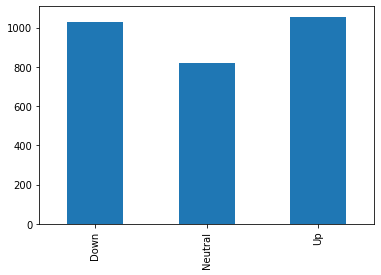

In [11]:
pv_1 = 0.005 # higher and lower than 0.5% return
pv_2 = 0.015 # higher and lower than 1.5% return
col = 'Close_ret' # Can also be 'Adj_close_ret'

num_classes = 3 # Choose 3 or 5

if num_classes == 3:

    mutli_class_buckets = Response[col].value_counts(bins = [Response[col].min(),-pv_2, pv_2,Response[col].max()])
    mutli_class_buckets.sort_index(ascending=True, inplace=True)
    mutli_class_buckets.index = ['Down','Neutral','Up']
    mutli_class_buckets.plot(kind='bar');

    Neutral = ((Response[col] > -pv_2) & (Response[col] < pv_2))
    Down = (Response[col] < -pv_2) 
    Up = (Response[col] > pv_2)

    conditions = [Down, Neutral, Up]
    choices = [-1, 0, 1]
    multi_class = np.select(conditions, choices, default=0)

    Target = pd.DataFrame(index = Response.index, data = multi_class)
    Target.columns = ['Labels']
    Response['Labels'] = Target.Labels.values
    print(Target.value_counts())

elif num_classes == 5:
    mutli_class_buckets = Response[col].value_counts(bins = [Response[col].min(),-pv_2, -pv_1,pv_1, pv_2,Response[col].max()])
    mutli_class_buckets.sort_index(ascending=True, inplace=True)
    mutli_class_buckets.index = ['Strong_Down','Down','Neutral','Up','Strong_Up']
    mutli_class_buckets.plot(kind='bar');

    Neutral = ((Response[col] > -pv_1) & (Response[col] < pv_1))
    Down = ((Response[col] > -pv_2) & (Response[col] < -pv_1))
    Up = ((Response[col] > pv_1) & (Response[col] < pv_2))
    Strong_Down = (Response[col] < -pv_2) 
    Strong_Up = (Response[col] > pv_2)

    conditions = [Strong_Down, Down, Neutral, Up, Strong_Up]
    choices = [-2, -1, 0, 1, 2]
    multi_class = np.select(conditions, choices, default=0)

    Target = pd.DataFrame(index = Response.index, data = multi_class)
    Target.columns = ['Labels']
    Response['Labels'] = Target.Labels.values
    print(Target.value_counts())


    -- Choose Response Variable here - LB_Close, Close_ret, Close_Up_Down, OR Adjusted Data from above

### Remove Variables with all NaNs
<div style="color: Green; font-size:22px;" class="alert alert-block alert-warning"> 
<b>To Do:</b> Check why these variables have NaNs
</div>


In [12]:
Variables_with_nans = set(Variables.columns) - set(Variables.drop(Variables.columns[Variables.isna().all()].to_list(), axis=1).columns)
Variables_with_nans

{'CFTClegacy ConcentrationGrossLT4TDRShortOl',
 'CFTClegacy TotalReportablePositionsLongAll',
 'LumberTracklumberexportus TotalLumberExports',
 'LumberTracknorthamericanproduction PrairiesAndEasternCanada',
 'LumberTracknorthamericanproduction TotalNorthAmerica',
 'LumberTracknorthamericanshipment PrairiesAndEasternCanada',
 'LumberTracknorthamericanshipment TotalNorthAmerica'}

In [13]:
Variables.drop(Variables.columns[Variables.isna().all()].to_list(), axis=1, inplace=True)
Variables.drop(Variables.columns[Variables.isnull().all()].to_list(), axis=1, inplace=True)
print(pd.Series(Variables.dtypes.values).value_counts())
print("Total Variables Left:",pd.Series(Variables.dtypes.values).value_counts().sum())


float64    744
int64       11
bool         7
dtype: int64
Total Variables Left: 762


In [14]:
Response.drop(Response.columns[Response.isna().all()].to_list(), axis=1, inplace=True)
Response.drop(Response.columns[Response.isnull().all()].to_list(), axis=1, inplace=True)
pd.Series(Response.dtypes.values).value_counts()

float64    6
int32      1
dtype: int64

### Change Bool cols (mostly date columns such as Is_year_end etc.) to int columns

In [15]:
list_of_bool_cols = Variables.columns[Variables.dtypes.values == 'bool'].to_list()
list_of_bool_cols_response = Response.columns[Response.dtypes.values == 'bool'].to_list()

for col in list_of_bool_cols:
    Variables[col] = Variables[col].astype(int)

for col in list_of_bool_cols_response:
    Response[col] = Response[col].astype(int)


### Sample weights - Removed Outliers from Response by replacing with IQR*1.5 upper and lower limits

**TODO** - 
1. If we put returns as Sample weights, he model will ignore all rows where returns equals 0 and that class will be under represented - Look at class_weight and sample_weight
2. sample_weight for fit method is clear but what does it mean to pass sample_weight to sklearn score method

In [16]:
col = 'Adj_Close_ret'
create_bins_data(Response, col, 10)

Max: 0.2677330876148725
Min: -0.4076413875307594


(-0.409, -0.333]      0.03
(-0.333, -0.258]      0.00
(-0.258, -0.183]      0.07
(-0.183, -0.107]      0.38
(-0.107, -0.0324]     6.65
(-0.0324, 0.0426]    89.05
(0.0426, 0.118]       3.62
(0.118, 0.193]        0.14
(0.193, 0.268]        0.07
Name: Adj_Close_ret, dtype: float64

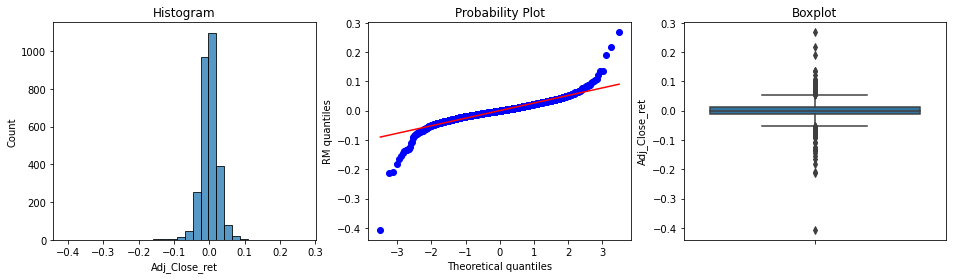

In [17]:
diagnostic_plots(Response, col)

In [18]:
cols_to_winsorize = ['Adj_Close_ret', 'Close_ret']

# Feature engine WINSORIZER
winsoriser = Winsorizer(capping_method='iqr', # choose iqr for IQR rule boundaries or gaussian for mean and std
                          tail='both', # cap left, right or both tails 
                          fold=1.5, # This is the in
                          variables=cols_to_winsorize)

winsoriser.fit(Response)
Response = winsoriser.transform(Response)
print(winsoriser.left_tail_caps_)
print(winsoriser.right_tail_caps_)

sample_weights = np.abs(Response['Adj_Close_ret'].values)
Response['sample_weights'] = sample_weights

# Since we are weighing each sample by returns, samples with return zero will be ignored by the model so need to increase its weight to maximum
Response.loc[Response['sample_weights'] < 0.005, 'sample_weights'] = sample_weights.max()


print(Response[['Labels','sample_weights']].groupby('Labels').sum())
print(Response[['Labels','sample_weights']].groupby('Labels').mean())

{'Adj_Close_ret': -0.053331250947187936, 'Close_ret': -0.12778431181013916}
{'Adj_Close_ret': 0.054557283268807044, 'Close_ret': 0.12813728261815127}
        sample_weights
Labels                
-1           29.987036
 0           21.428891
 1           30.112441
        sample_weights
Labels                
-1            0.029114
 0            0.026197
 1            0.028543


In [19]:
create_bins_data(Response, 'sample_weights', 10)

Max: 0.054557283268807044
Min: 0.005034412378459585


(0.00403, 0.0105]    19.91
(0.0105, 0.016]      16.05
(0.016, 0.0215]      12.99
(0.0215, 0.027]       8.27
(0.027, 0.0325]       6.68
(0.0325, 0.038]       5.06
(0.038, 0.0436]       3.03
(0.0436, 0.0491]      2.14
(0.0491, 0.0546]     25.87
Name: sample_weights, dtype: float64

### EVALUATION METRICS & generate_sample_confusion_matrix
    1. Recall/Sensitivity/TPR: tp / (tp + fn) - **%age of a TRUE/Positives class correctly identified/ ability to find all the positive samples**. This deciedes how many times we trade since its the propotion of actual positives we are able to detect.
    2. Specificity (TNR) is tn / (tn + fp) - %age of a FALSE/Negatives class correctly identified
    3. False Positive Rate (FPR) = 1 - Specificity or fp / (tn + fp). 
    4. Accuracy is TP/ entire matrix sum ???
    5. Precision is tp / (tp + fp) - the ability not to label a negative sample as positive. This deciedes our PROFITABILITY since we don't want FALSE Positives
    6. Support is the number of occurrences of each class  - sum of respective row
    7. Macro - unweighted mean. This does not take label imbalance into account.
    8. Wt_Avg - average weighted by support
    9. Micro - same as accuracy - sum of diagnols/ sum of all matrix

**True/False (Positives/Negatives) means if a sample belongs/doesn't belong to a class**


In [20]:
lab = Response.Labels.unique()
lab.sort()

generate_sample_confusion_matrix(-1,lab)

### Blocked Time Series cross-validation
https://goldinlocks.github.io/Time-Series-Cross-Validation/

In [21]:
btscv = BlockingTimeSeriesSplit(n_splits=5)

**These metrics (weighted & average) do NOT exactly match the output of features_df metrics** 
** Also note that the weighted average results are not based on sample_weights for now

### Metrics from Confusion Matrix Custom Func

In [22]:
def metrics_from_cm(cm, lab = sorted(Response['Labels'].unique())):

    df = pd.DataFrame()
    pre = {}
    rec = {}
    tp = {}
    tn = {}
    fp = {}
    fn = {}
    weighted_average = {}
    for cat in lab:
        pre[cat] = np.nan_to_num(cm.loc[cat,cat]/cm.sum(axis=0).loc[cat], nan=0.0, posinf=0.0, neginf=0.0)
        rec[cat] = np.nan_to_num(cm.loc[cat,cat]/cm.sum(axis=1).loc[cat], nan=0.0, posinf=0.0, neginf=0.0)
        tp[cat] = cm.loc[cat, cat]
        tn[cat] = cm.drop(cat,axis=1).drop(cat,axis=0).sum().sum()
        fp[cat] = cm[cat].drop(cat).sum()
        fn[cat] = cm.loc[cat].drop(cat).sum()

    df = pd.concat([pd.DataFrame.from_dict(pre,orient='index', columns=['precision']),pd.DataFrame.from_dict(rec,orient='index', columns=['recall'])], axis=1)
    df['fscore'] = (2 * ((df.precision * df.recall) / (df.precision + df.recall))).fillna(0)
    df['tp'] = pd.Series(tp)
    df['tn'] = pd.Series(tn)
    df['fp'] = pd.Series(fp)
    df['fn'] = pd.Series(fn)

    df['specificity'] =  pd.Series(df.tn / (df.tn + df.fp))
    df['fpr'] = pd.Series(df.fp / (df.tn + df.fp))
    df['accuracy'] = (df.tp + df.tn) / (df.tp + df.tn + df.fp + df.fn)
    df['support'] = cm.sum(axis=1)

    main_metrics_list = ['precision', 'recall', 'fscore', 'specificity','fpr', 'accuracy']
    df_perc = df[main_metrics_list]
    df = pd.concat([df_perc,df.tp,df.tn,df.fp,df.fn,df.support], axis=1)

    # Weighted average
    for cols in df.columns:
        if cols in main_metrics_list:
            weighted_average[cols] = df[cols].dot(df.support)/df.support.sum()
        else:
            weighted_average[cols] = None

    df.loc['macro',main_metrics_list] = df[main_metrics_list].mean()

    weight_df = pd.DataFrame.from_dict(weighted_average,orient='index', columns=['Wt_Avg']).T
    df = pd.concat([df, weight_df], axis=0)

    # % Formatting
    for col in main_metrics_list:
        try:
            df[col] = df[col].mul(100).round(0).astype(int).astype(str).add('%')
        except:
            pass
    other_list = ['tp', 'tn', 'fp', 'fn', 'support']

    df.loc['macro', other_list] = df.loc[lab, other_list] .sum()
    df.loc['Wt_Avg', other_list] = df.loc[lab, other_list] .sum()

    return df


In [23]:
# https://stackoverflow.com/questions/42562146/classification-report-with-nested-cross-validation-in-sklearn-average-individua
def predictions_from_custom_cross_val(model,X, y, custom_cv = btscv, sampled_weights=False):    
    # Variables to store original and predicted values
    original = []
    predicted = []

    def score_func(y_true, y_pred):
        original.extend(y_true)
        predicted.extend(y_pred)

    if sampled_weights:
    # Cross Val Score with SAMPLE WeIGHTS        
        scores = cross_val_score(model, X, y.Labels, cv=btscv, scoring=make_scorer(score_func),fit_params={'sample_weight':np.abs(y.sample_weights.values)} ) #,error_score="raise"
    else:
        scores = cross_val_score(model, X, y.Labels, cv=btscv, scoring=make_scorer(score_func) ) #,error_score="raise"
    return original, predicted

### Helper Functions

In [24]:
def fill_with_dataset(new_dataset,original_dataset):
    X_train_dict[new_dataset] = X_train_dict[original_dataset]
    X_test_dict[new_dataset] = X_test_dict[original_dataset]
    X_val_dict[new_dataset] = X_val_dict[original_dataset]

In [25]:
def add_to_features_df(model,dataset):
    model_name = type(model).__name__
    features_df.loc[(model_name, dataset),'Num_Features'] = len(X_train_dict[dataset].columns) # so can store list of features
    features_df.loc[(model_name, dataset),'Features_List'] = X_train_dict[dataset].columns.to_list()

    original_list = set(features_df.loc[(model_name, 'Original'),'Features_List'])
    dataset_list = set(features_df.loc[(model_name, dataset),'Features_List'])
    removed_list = list(sorted(original_list - dataset_list))
    
    features_df.loc[(model_name, dataset),'Removed_Features'] = removed_list
    features_df.loc[(model_name, dataset),'Model_Details'] = model
    

In [26]:
def get_shapes(dataset):
    print("\nShapes for dataset:",dataset)
    print("X_train Shape",X_train_dict[dataset].shape)
    print("X_test Shape",X_test_dict[dataset].shape)
    print("X_val Shape",X_val_dict[dataset].shape)
    # print("y_train Shape",y_train.shape)
    # print("y_test Shape",y_test.shape)
    # print("y_val Shape",y_val.shape)

In [27]:
def print_pipe_removed(pipe):
    total_removed = 0
    print("\nRemoved Features for Pipeline:",pipe)
    for i in range(len(pipe.steps)):
        step_name = pipe.steps[i][0]
        total_removed += len(pipe.named_steps[step_name].features_to_drop_)
        print(step_name, ":",len(pipe.named_steps[step_name].features_to_drop_))
    print("Total removed:",total_removed)

In [28]:
def remove_features(dataset,pipe):
    print("\nRemoving Features for dataset:",dataset)
    print("# Features before:",len(X_train_dict[dataset].columns.to_list()))
    X_train_dict[dataset] = pipe.transform(X_train_dict[dataset])
    X_test_dict[dataset] = pipe.transform(X_test_dict[dataset])
    X_val_dict[dataset] = pipe.transform(X_val_dict[dataset])

In [29]:
def keep_features(dataset,feats_to_keep_list):
    print("\nRemoving Features for dataset:",dataset)
    print("# Features before:",len(X_train_dict[dataset].columns.to_list()))
    X_train_dict[dataset] = X_train_dict[dataset][feats_to_keep_list]
    X_test_dict[dataset] = X_test_dict[dataset][feats_to_keep_list]
    X_val_dict[dataset] = X_val_dict[dataset][feats_to_keep_list]


*****Change between Labels & Close_Up_Down columns for y_combined to make it either a Multiclass (5) or (3)***

In [30]:
# **cross_val_score - accuracy_score**                                                      
# scoring https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules

def add_metrics(model,dataset,set='combined', sampled_weights=False):

    model_name = type(model).__name__
    metrics_list = ['balanced_accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted','neg_log_loss']

    # Using BlockedTimeSeriesSplit cross val to calculate metrics
    if set == 'train':
        X = X_train_dict[dataset].sort_index()
        y = y_train.sort_index() 
    elif set == 'test':
        X = X_test_dict[dataset].sort_index()
        y = y_test.sort_index() 
    elif set == 'combined':
        X = pd.concat([X_train_dict[dataset],X_test_dict[dataset]]).sort_index()
        y = pd.concat([y_train,y_test]).sort_index()    

    for metric in metrics_list:

        if sampled_weights:
        # cross_val_score with SAMPLE_WEIGHTS
            score = cross_val_score(model, X, y.Labels, cv=btscv, scoring = str(metric),fit_params={'sample_weight':np.abs(y.sample_weights.values)}) #,error_score="raise"
        else:
            score = cross_val_score(model, X, y.Labels, cv=btscv, scoring = str(metric)) #,error_score="raise"
            
        features_df.loc[(model_name, dataset),metric]= round(np.mean(score),2)

    # Calculating Class Wise Metrics
    original, predicted = predictions_from_custom_cross_val(model,X, y, custom_cv = btscv, sampled_weights=sampled_weights)
    cm = pd.DataFrame(confusion_matrix(original, predicted), index=lab, columns=lab)
    all_class_metric = metrics_from_cm(cm)

    # Calculating Kappa Score 

    if sampled_weights:
    # Kappa with SAMPLE_WEIGHTS
        sample_weights = y.sample_weights.iloc[get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5)['test']].values.tolist()
        kappa_score = cohen_kappa_score(original, predicted, sample_weight=sample_weights)
    else:
        kappa_score = cohen_kappa_score(original, predicted)
    
    features_df.loc[(model_name, dataset),'Kappa']= kappa_score
    
    # Insert the dataframe in a cell in features_df
    features_df.loc[(model_name, dataset),'ClassDf'] = np.array([])
    features_df.loc[(model_name, dataset),'ClassDf'].astype(object)
    features_df.loc[(model_name, dataset),'ClassDf'] =  [all_class_metric]

        

### For Model Metrics

###### NOTE THE MODEL PIPELINES ARE BEING CHECKED/FITTED TO TRAINING DATA WHILE THE METRICS ARE calculated ON Set option in func argument

In [31]:
# This function does the following steps:
# 1. Fill the dataset with passed X Variables
# 2. Fit Pipeline function
# 3. Remove features/Transform train, test, val
# 4. Add features to features_df
# 5. Print_pipe_removed
# 6. Get Shapes
# 7. Add metrics to features_df using Blocked Time Series Cross Validation with TEST set

#  = DropConstantFeatures(tol=1, variables=None, missing_values='raise')
def apply_pipe_transform(dataset,original_dataset, pipe, model, set='combined'):
    fill_with_dataset(dataset,original_dataset)
    # named_step_sample_weight=np.abs(y_train.Adj_Close_ret.values)
    pipe = pipe.fit(X_train_dict[dataset])
    remove_features(dataset,pipe)
    add_to_features_df(model,dataset)
    print_pipe_removed(pipe)
    get_shapes(dataset)
    add_metrics(model, dataset, set='combined')


def insert_model_stats(dataset,original_dataset, feats_to_keep_list, model, set='combined', sampled_weights=False):
    fill_with_dataset(dataset,original_dataset)
    keep_features(dataset,feats_to_keep_list)
    model.fit(X_train_dict[dataset][feats_to_keep_list], y_train.Labels)
    add_to_features_df(model,dataset)
    get_shapes(dataset)
    add_metrics(model, dataset, set='combined', sampled_weights=sampled_weights)
    

### Create List of Models for both Classifiers & Regressors

In [32]:
# Not using xgb_clf for now because it is too slow

rf_clf = RandomForestClassifier(n_estimators=200, max_depth=3, n_jobs=-1)
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1,eval_metric='mlogloss')


models = [rf_clf,xgb_clf]
# models = [rf_clf]

### Dataframe to Store Model Features & Metrics

In [33]:
model_names = [type(m).__name__ for m in models]
dataset = 'Original'
multilevel_index = pd.MultiIndex.from_product([model_names,[dataset]],names=['Model', 'Dataset'])
cols_names = ['Model_Details','Num_Features','Features_List','Removed_Features'] + ['balanced_accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted','neg_log_loss','Kappa','ClassDf']
features_df = pd.DataFrame(columns=cols_names, index=multilevel_index)

### Splitting the Dataset in 3 Dictionaries of Training, Testing & Validation & Initiating features_df

###### Note: If metric calculations in add_metric function is calculated on Data which has even one class missing from y_predictions, it will throw an error (when error='raise' used), or it will be NaN for (roc_auc_ovr_weighted & roc_auc_ovo_weighted) if this option is not used in cross_val_score..


In [34]:
X_train_dict = {}
X_test_dict = {}
X_val_dict = {}

# To make sure test is the most recent
Variables.sort_index(ascending = True, inplace = True) 
Response.sort_index(ascending = True, inplace = True)

Validation_date_start = '2022-01-01'
X_val_dict['Original'] = Variables[Variables.index >= Validation_date_start]
y_val = Response[Response.index >= Validation_date_start]

X_train_dict['Original'], X_test_dict['Original'], y_train, y_test = train_test_split(Variables[Variables.index < Validation_date_start],\
     Response[Response.index < Validation_date_start], test_size=0.50, shuffle = False)

for m in models:
    add_to_features_df(m,dataset='Original')
    add_metrics(m,dataset='Original',set='combined')  


# Shapes
get_shapes(dataset = 'Original')


Shapes for dataset: Original
X_train Shape (1385, 762)
X_test Shape (1386, 762)
X_val Shape (132, 762)


### ***Functions to plot Blocked TimeSeries Split****

The horizontal axis is the training set size while the vertical axis represents the cross-validation iterations. The folds used for training are depicted in blue and the folds used for validation are depicted in orange. The final horizontal bar are the FIVE [-2,-1,0,1,2] class labels for the response variable


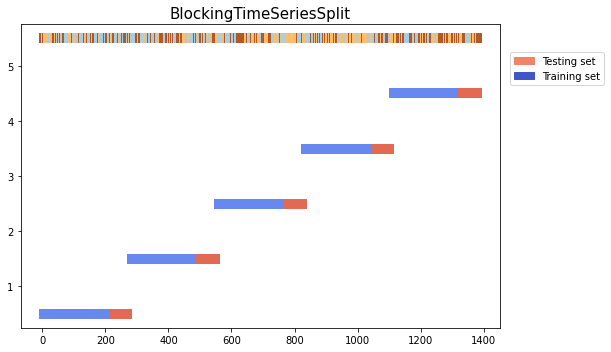

In [35]:

n_splits = 5
cv = BlockingTimeSeriesSplit
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

print("The horizontal axis is the training set size while the vertical axis represents the cross-validation iterations. The folds used for training are depicted in blue and the folds used for validation are depicted in orange. The final horizontal bar are the FIVE [-2,-1,0,1,2] class labels for the response variable")
plot_timeseries_split(np.array(X_train_dict['Original']),np.array(y_train.Labels),n_splits,cmap_cv,cmap_data,cv)


### Remove all constant Variables
<div style="color: Green; font-size:22px;" class="alert alert-block alert-warning"> 
<b>To Do:</b> Check why the following features have only one value
</div>

In [36]:
# Issue with using XGBOOST - takes long time and gives warnigs Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

warnings.filterwarnings("ignore")

dataset = 'Constant'
pipe = Pipeline([(dataset, DropConstantFeatures(tol=1, variables=None, missing_values='raise'))])
apply_pipe_transform(dataset,'Original', pipe, models[0], set='combined')
apply_pipe_transform(dataset,'Original', pipe, models[1], set='combined')


Removing Features for dataset: Constant
# Features before: 762

Removed Features for Pipeline: Pipeline(steps=[('Constant', DropConstantFeatures())])
Constant : 102
Total removed: 102

Shapes for dataset: Constant
X_train Shape (1385, 660)
X_test Shape (1386, 660)
X_val Shape (132, 660)

Removing Features for dataset: Constant
# Features before: 762

Removed Features for Pipeline: Pipeline(steps=[('Constant', DropConstantFeatures())])
Constant : 102
Total removed: 102

Shapes for dataset: Constant
X_train Shape (1385, 660)
X_test Shape (1386, 660)
X_val Shape (132, 660)


### Build 1 Model with 1 Feature only

In [37]:
original_dataset = 'Original'
dataset = 'Spread_1-2'
model = models[0]
feats_to_keep_list = ['LumberContractSpreads FirstSecond']
insert_model_stats(dataset,original_dataset, feats_to_keep_list, model, set='combined')




Removing Features for dataset: Spread_1-2
# Features before: 762

Shapes for dataset: Spread_1-2
X_train Shape (1385, 1)
X_test Shape (1386, 1)
X_val Shape (132, 1)


In [38]:
X = pd.concat([X_train_dict[dataset],X_test_dict[dataset]]).sort_index()
y = pd.concat([y_train,y_test]).sort_index() 


original, predicted = predictions_from_custom_cross_val(model,X, y, custom_cv = btscv)
cm = pd.DataFrame(confusion_matrix(original, predicted), index=lab, columns=lab)
all_class_metric = metrics_from_cm(cm)

In [39]:
cm

,-1,0,1
-1,74,39,53
0,81,65,58
1,91,40,54


In [40]:
features_df.loc[('RandomForestClassifier','Spread_1-2')]['ClassDf'][0]

,precision,recall,fscore,specificity,fpr,accuracy,tp,tn,fp,fn,support
-1,30%,45%,36%,55%,45%,52%,74.0,215.0,174.0,92.0,166.0
0,45%,32%,37%,77%,23%,61%,65.0,272.0,79.0,139.0,204.0
1,32%,28%,30%,70%,30%,56%,52.0,259.0,111.0,133.0,185.0
macro,36%,35%,34%,68%,32%,56%,191.0,746.0,364.0,364.0,555.0
Wt_Avg,36%,34%,34%,68%,32%,57%,191.0,746.0,364.0,364.0,555.0


In [41]:
features_df.loc[('RandomForestClassifier','Spread_1-2')]

Model_Details           (DecisionTreeClassifier(max_depth=3, max_featu...
Num_Features                                                            1
Features_List                         [LumberContractSpreads FirstSecond]
Removed_Features        [CFTCdisaggregated ChangeinMMoneyLongAll, CFTC...
balanced_accuracy                                                    0.34
precision_weighted                                                   0.36
recall_weighted                                                      0.35
f1_weighted                                                          0.28
roc_auc_ovr_weighted                                                 0.51
roc_auc_ovo_weighted                                                 0.52
neg_log_loss                                                        -1.13
Kappa                                                            0.025593
ClassDf                   [[precision, recall, fscore, specificity, fpr]]
Name: (RandomForestClassifier, Spread_

### Remove Quasi-constant features

In [42]:
dataset = 'QuasiConstant'
pipe = Pipeline([(dataset, DropConstantFeatures(tol=0.95, variables=None, missing_values='raise'))])
apply_pipe_transform(dataset,'Original', pipe, models[0], set='combined')


Removing Features for dataset: QuasiConstant
# Features before: 762

Removed Features for Pipeline: Pipeline(steps=[('QuasiConstant', DropConstantFeatures(tol=0.95))])
QuasiConstant : 110
Total removed: 110

Shapes for dataset: QuasiConstant
X_train Shape (1385, 652)
X_test Shape (1386, 652)
X_val Shape (132, 652)


### Remove Duplicated Features

In [43]:
dataset = 'Duplicated'
pipe = Pipeline([(dataset, DropDuplicateFeatures(variables=None, missing_values='raise')),])
apply_pipe_transform(dataset,'Original', pipe, models[0], set='combined')


Removing Features for dataset: Duplicated
# Features before: 762

Removed Features for Pipeline: Pipeline(steps=[('Duplicated', DropDuplicateFeatures(missing_values='raise'))])
Duplicated : 88
Total removed: 88

Shapes for dataset: Duplicated
X_train Shape (1385, 674)
X_test Shape (1386, 674)
X_val Shape (132, 674)


### Remove Duplicated & Quasi Constant Features

In [44]:
dataset = 'Dupl&QConstant'
pipe = Pipeline([(dataset, DropDuplicateFeatures(variables=None, missing_values='raise')),])
apply_pipe_transform(dataset,'QuasiConstant', pipe, models[0], set='combined')


Removing Features for dataset: Dupl&QConstant
# Features before: 652

Removed Features for Pipeline: Pipeline(steps=[('Dupl&QConstant',
                 DropDuplicateFeatures(missing_values='raise'))])
Dupl&QConstant : 48
Total removed: 48

Shapes for dataset: Dupl&QConstant
X_train Shape (1385, 604)
X_test Shape (1386, 604)
X_val Shape (132, 604)


### Remove Correlated Features

In [45]:
warnings.filterwarnings("ignore")

smart_correlation_estimator = models[0]
dataset = 'Correlated'
pipe = Pipeline([(dataset, SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.95,missing_values="raise",selection_method="variance",estimator=smart_correlation_estimator,scoring="roc_auc",cv=btscv,)),])
apply_pipe_transform(dataset,'Original', pipe, models[0], set='combined')


Removing Features for dataset: Correlated
# Features before: 762

Removed Features for Pipeline: Pipeline(steps=[('Correlated',
                 SmartCorrelatedSelection(cv=<support._model_build_func.BlockingTimeSeriesSplit object at 0x000001C7368EA4A0>,
                                          estimator=RandomForestClassifier(max_depth=3,
                                                                           n_estimators=200,
                                                                           n_jobs=-1),
                                          method='spearman',
                                          missing_values='raise',
                                          selection_method='variance',
                                          threshold=0.95))])
Correlated : 248
Total removed: 248

Shapes for dataset: Correlated
X_train Shape (1385, 514)
X_test Shape (1386, 514)
X_val Shape (132, 514)


### Remove Duplicated, Quasi Constant & Correlated Features

In [46]:
warnings.filterwarnings("ignore")
smart_correlation_estimator = models[0]
dataset = 'Clean'
pipe = Pipeline([(dataset, SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.95,missing_values="raise",selection_method="variance",estimator=smart_correlation_estimator,scoring="roc_auc",cv=btscv,)),])
apply_pipe_transform(dataset,'Dupl&QConstant', pipe, models[0], set='combined')



Removing Features for dataset: Clean
# Features before: 604

Removed Features for Pipeline: Pipeline(steps=[('Clean',
                 SmartCorrelatedSelection(cv=<support._model_build_func.BlockingTimeSeriesSplit object at 0x000001C7368EA4A0>,
                                          estimator=RandomForestClassifier(max_depth=3,
                                                                           n_estimators=200,
                                                                           n_jobs=-1),
                                          method='spearman',
                                          missing_values='raise',
                                          selection_method='variance',
                                          threshold=0.95))])
Clean : 200
Total removed: 200

Shapes for dataset: Clean
X_train Shape (1385, 404)
X_test Shape (1386, 404)
X_val Shape (132, 404)


### Clean1 - Drop constant, quasi Constant, duplicated and correlated features

In [47]:
warnings.filterwarnings("ignore")

smart_correlation_estimator = models[0]
dataset = 'Clean1'
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasiConstant', DropConstantFeatures(tol=0.95, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures(variables=None, missing_values='raise')),
    ('correlation', SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.95,missing_values="raise",selection_method="variance",estimator=smart_correlation_estimator,scoring="roc_auc",cv=btscv,)),])
apply_pipe_transform(dataset,'Original', pipe, models[0], set='combined')
apply_pipe_transform(dataset,'Original', pipe, models[1], set='combined')


Removing Features for dataset: Clean1
# Features before: 762

Removed Features for Pipeline: Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasiConstant', DropConstantFeatures(tol=0.95)),
                ('duplicated', DropDuplicateFeatures(missing_values='raise')),
                ('correlation',
                 SmartCorrelatedSelection(cv=<support._model_build_func.BlockingTimeSeriesSplit object at 0x000001C7368EA4A0>,
                                          estimator=RandomForestClassifier(max_depth=3,
                                                                           n_estimators=200,
                                                                           n_jobs=-1),
                                          method='spearman',
                                          missing_values='raise',
                                          selection_method='variance',
                                          threshold=0.95))])
constant : 102
quasi

In [48]:
features_df.drop(['Model_Details','Features_List','Removed_Features','ClassDf'],axis=1)

Num_Features balanced_accuracy  \
Model                  Dataset                                         
RandomForestClassifier Original                762              0.41   
XGBClassifier          Original                762              0.42   
RandomForestClassifier Constant                660              0.41   
XGBClassifier          Constant                660              0.42   
RandomForestClassifier Spread_1-2                1              0.34   
                       QuasiConstant           652              0.42   
                       Duplicated              674              0.43   
                       Dupl&QConstant          604              0.43   
                       Correlated              514              0.42   
                       Clean                   404              0.41   
                       Clean1                  404              0.42   
XGBClassifier          Clean1                  404              0.43   

                                      precision_weighted recall_weighted  \
Model                  Dataset                                             
RandomForestClassifier Original                     0.35            0.42   
XGBClassifier          Original                     0.42            0.42   
RandomForestClassifier Constant                     0.39            0.42   
XGBClassifier          Constant                     0.43            0.42   
RandomForestClassifier Spread_1-2                   0.36            0.35   
                       QuasiConstant                0.37            0.42   
                       Duplicated                   0.36            0.41   
                       Dupl&QConstant               0.34            0.41   
                       Correlated                   0.35            0.43   
                       Clean                        0.36            0.43   
                       Clean1                       0.34            0.43   
XGBClassifier          Clean1                       0.44            0.42   

                                      f1_weighted roc_auc_ovr_weighted  \
Model                  Dataset                                           
RandomForestClassifier Original              0.35                 0.62   
XGBClassifier          Original              0.38                  0.6   
RandomForestClassifier Constant              0.36                 0.62   
XGBClassifier          Constant              0.38                  0.6   
RandomForestClassifier Spread_1-2            0.28                 0.51   
                       QuasiConstant         0.36                 0.62   
                       Duplicated            0.36                 0.62   
                       Dupl&QConstant        0.36                 0.61   
                       Correlated            0.36                 0.62   
                       Clean                 0.36                 0.63   
                       Clean1                0.36                 0.63   
XGBClassifier          Clean1                0.38                  0.6   

                                      roc_auc_ovo_weighted neg_log_loss  \
Model                  Dataset                                            
RandomForestClassifier Original                       0.63        -1.06   
XGBClassifier          Original                       0.61        -1.64   
RandomForestClassifier Constant                       0.62        -1.07   
XGBClassifier          Constant                        0.6        -1.66   
RandomForestClassifier Spread_1-2                     0.52        -1.13   
                       QuasiConstant                  0.62        -1.07   
                       Duplicated                     0.63        -1.07   
                       Dupl&QConstant                 0.61        -1.07   
                       Correlated                     0.62        -1.07   
                       Clean                          0.63        -1.06   
                       Clea

**

In [49]:
features_df.drop(['Model_Details','Features_List','Removed_Features'],axis=1).loc[('RandomForestClassifier','Clean1')]['ClassDf'][0]

,precision,recall,fscore,specificity,fpr,accuracy,tp,tn,fp,fn,support
-1,36%,43%,39%,67%,33%,60%,72.0,260.0,129.0,94.0,166.0
0,45%,34%,39%,75%,25%,60%,70.0,265.0,86.0,134.0,204.0
1,44%,48%,46%,70%,30%,63%,88.0,260.0,110.0,97.0,185.0
macro,42%,42%,41%,71%,29%,61%,230.0,785.0,325.0,325.0,555.0
Wt_Avg,42%,41%,41%,71%,29%,61%,230.0,785.0,325.0,325.0,555.0


In [50]:
'f1_weighted', 'neg_log_loss', 'cohen_kappa_score', 'precision_weighted','roc_auc_ovr_weighted'

('f1_weighted',
 'neg_log_loss',
 'cohen_kappa_score',
 'precision_weighted',
 'roc_auc_ovr_weighted')

## Manual Feature Selection

To Do

**Engineered**
1. LB_High - LB_Low
2. Get Other Basis
3. Use some techincal Indicators

**Raw**
1. LB_Volume	
2. LB_openInterest



### Read List

In [51]:
# pd.Series(Variables.columns.tolist()).to_csv('Variable_columns_names.csv',index=False)

manual_list = pd.read_excel('C:/source/2x4-data/app/feature_selection/ManualSelectList.xlsx', index_col=0)
manual_list = manual_list[manual_list.index == 1]
manual_list = manual_list.values.tolist()
manual_list = [x for xs in manual_list for x in xs]

### Apply all Transformations

In [52]:

def fill_with_manual_list(new_dataset,manual_list):
    X_train_dict[new_dataset] = X_train_dict['Original'][manual_list]
    X_test_dict[new_dataset] = X_test_dict['Original'][manual_list]
    X_val_dict[new_dataset] = X_val_dict['Original'][manual_list]


def apply_pipe_transform_2(dataset,original_dataset, pipe, manual_list, model, sampled_weights, set='combined'):
    fill_with_manual_list(dataset, manual_list)
    pipe = pipe.fit(X_train_dict[dataset])
    remove_features(dataset,pipe)
    print_pipe_removed(pipe)
    get_shapes(dataset)
    add_metrics(model, dataset, set='combined')

In [53]:
warnings.filterwarnings("ignore")

dataset='ManualSelection'
original_dataset='Original'
feats_to_keep_list=manual_list
model=models[0]
set='combined'
sampled_weights=False

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasiConstant', DropConstantFeatures(tol=0.90, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures(variables=None, missing_values='raise')),
    ('correlation', SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.95,missing_values="raise",selection_method="variance",estimator=model,scoring="precision_weighted",cv=btscv,)),])
apply_pipe_transform_2(dataset,'Original', pipe, manual_list, models[0], set='combined', sampled_weights=True)
apply_pipe_transform_2(dataset,'Original', pipe, manual_list, models[1], set='combined', sampled_weights=True)


Removing Features for dataset: ManualSelection
# Features before: 148

Removed Features for Pipeline: Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasiConstant', DropConstantFeatures(tol=0.9)),
                ('duplicated', DropDuplicateFeatures(missing_values='raise')),
                ('correlation',
                 SmartCorrelatedSelection(cv=<support._model_build_func.BlockingTimeSeriesSplit object at 0x000001C7368EA4A0>,
                                          estimator=RandomForestClassifier(max_depth=3,
                                                                           n_estimators=200,
                                                                           n_jobs=-1),
                                          method='spearman',
                                          missing_values='raise',
                                          scoring='precision_weighted',
                                          selection_method='variance',
 

### Save Below

In [54]:
X = pd.concat([X_train_dict['Original'],X_test_dict['Original']],axis=0)
y = pd.concat([y_train,y_test],axis=0)
model = models[0]

In [55]:
com1_original, com1_predicted = predictions_from_custom_cross_val(model,X, y, custom_cv = btscv, sampled_weights=False)
com2_original, com2_predicted = predictions_from_custom_cross_val(model,X, y, custom_cv = btscv, sampled_weights=True)
com1_original == com2_original, com1_predicted == com2_predicted


(True, False)

In [56]:

pd.DataFrame(data = [pd.Series(com1_predicted).value_counts().sort_index(), pd.Series(com1_original).value_counts().sort_index()], index = ['predicted','original']).T



,predicted,original
-1,203,166
0,136,204
1,216,185


In [57]:
pd.DataFrame(data = [pd.Series(com2_predicted).value_counts().sort_index(), pd.Series(com2_original).value_counts().sort_index()], index = ['predicted','original']).T


,predicted,original
-1,215,166
0,127,204
1,213,185


In [58]:
# class_weight='balanced'



In [59]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
class_weights = compute_class_weight(class_weight = "balanced",classes= lab, y = y.Labels)
computed_sample_weights = compute_sample_weight('balanced', y.Labels)
class_weights

array([0.94637978, 1.17068019, 0.91815772])

In [60]:
computed_sample_weights

array([0.91815772, 0.94637978, 1.17068019, ..., 0.94637978, 0.94637978,
       1.17068019])

In [61]:
group_df = pd.DataFrame(data = [computed_sample_weights, y.Labels], index = ['computed_sample_weights','Labels']).T
group_df
group_df.groupby('Labels').mean()

,computed_sample_weights
Labels,
-1.0,0.946380
0.0,1.170680
1.0,0.918158


In [62]:
Response[['Labels','sample_weights']].groupby('Labels').sum()
# Response[['Labels','sample_weights']].groupby('Labels').mean()


,sample_weights
Labels,
-1,29.987036
0,21.428891
1,30.112441


In [63]:

create_bins_data(Response,'sample_weights',10)

Max: 0.054557283268807044
Min: 0.005034412378459585


(0.00403, 0.0105]    19.91
(0.0105, 0.016]      16.05
(0.016, 0.0215]      12.99
(0.0215, 0.027]       8.27
(0.027, 0.0325]       6.68
(0.0325, 0.038]       5.06
(0.038, 0.0436]       3.03
(0.0436, 0.0491]      2.14
(0.0491, 0.0546]     25.87
Name: sample_weights, dtype: float64

In [64]:
features_df.drop(['Model_Details','Features_List','Removed_Features','ClassDf'],axis=1)

Num_Features balanced_accuracy  \
Model                  Dataset                                          
RandomForestClassifier Original                 762              0.41   
XGBClassifier          Original                 762              0.42   
RandomForestClassifier Constant                 660              0.41   
XGBClassifier          Constant                 660              0.42   
RandomForestClassifier Spread_1-2                 1              0.34   
                       QuasiConstant            652              0.42   
                       Duplicated               674              0.43   
                       Dupl&QConstant           604              0.43   
                       Correlated               514              0.42   
                       Clean                    404              0.41   
                       Clean1                   404              0.42   
XGBClassifier          Clean1                   404              0.43   
RandomForestClassifier ManualSelection          NaN              0.41   
XGBClassifier          ManualSelection          NaN              0.42   

                                       precision_weighted recall_weighted  \
Model                  Dataset                                              
RandomForestClassifier Original                      0.35            0.42   
XGBClassifier          Original                      0.42            0.42   
RandomForestClassifier Constant                      0.39            0.42   
XGBClassifier          Constant                      0.43            0.42   
RandomForestClassifier Spread_1-2                    0.36            0.35   
                       QuasiConstant                 0.37            0.42   
                       Duplicated                    0.36            0.41   
                       Dupl&QConstant                0.34            0.41   
                       Correlated                    0.35            0.43   
                       Clean                         0.36            0.43   
                       Clean1                        0.34            0.43   
XGBClassifier          Clean1                        0.44            0.42   
RandomForestClassifier ManualSelection               0.39            0.41   
XGBClassifier          ManualSelection               0.44            0.41   

                                       f1_weighted roc_auc_ovr_weighted  \
Model                  Dataset                                            
RandomForestClassifier Original               0.35                 0.62   
XGBClassifier          Original               0.38                  0.6   
RandomForestClassifier Constant               0.36                 0.62   
XGBClassifier          Constant               0.38                  0.6   
RandomForestClassifier Spread_1-2             0.28                 0.51   
                       QuasiConstant          0.36                 0.62   
                       Duplicated             0.36                 0.62   
                       Dupl&QConstant         0.36                 0.61   
                       Correlated             0.36                 0.62   
                       Clean                  0.36                 0.63   
                       Clean1                 0.36                 0.63   
XGBClassifier          Clean1                 0.38                  0.6   
RandomForestClassifier ManualSelection        0.31                 0.63   
XGBClassifier          ManualSelection        0.35                 0.61   

                                       roc_auc_ovo_weighted neg_log_loss  \
Model                  Dataset                                             
RandomForestClassifier Original                        0.63        -1.06   
XGBClassifier          Original                        0.61        -1.64   
RandomForestClassifier Constant                        0.62        -1.07   
XGBClassifier          Constant                         

In [65]:
features_df.loc[('RandomForestClassifier','ManualSelection')]['ClassDf'][0]

,precision,recall,fscore,specificity,fpr,accuracy,tp,tn,fp,fn,support
-1,36%,40%,38%,70%,30%,61%,66.0,273.0,116.0,100.0,166.0
0,44%,40%,42%,71%,29%,59%,82.0,248.0,103.0,122.0,204.0
1,41%,42%,42%,70%,30%,61%,78.0,260.0,110.0,107.0,185.0
macro,41%,41%,41%,70%,30%,60%,226.0,781.0,329.0,329.0,555.0
Wt_Avg,41%,41%,41%,70%,30%,60%,226.0,781.0,329.0,329.0,555.0


In [66]:
features_df.loc[('RandomForestClassifier','Clean1')]['ClassDf'][0]

,precision,recall,fscore,specificity,fpr,accuracy,tp,tn,fp,fn,support
-1,36%,43%,39%,67%,33%,60%,72.0,260.0,129.0,94.0,166.0
0,45%,34%,39%,75%,25%,60%,70.0,265.0,86.0,134.0,204.0
1,44%,48%,46%,70%,30%,63%,88.0,260.0,110.0,97.0,185.0
macro,42%,42%,41%,71%,29%,61%,230.0,785.0,325.0,325.0,555.0
Wt_Avg,42%,41%,41%,71%,29%,61%,230.0,785.0,325.0,325.0,555.0


In [67]:
feats_to_keep_list = ['LumberContractSpreads FirstSecond','lumbermovingaverages MA200']

In [68]:
original_dataset = 'Original'
dataset = 'Spread_1-2_wts'
model = models[0]
feats_to_keep_list = ['LumberContractSpreads FirstSecond','lumbermovingaverages MA200']
insert_model_stats(dataset,original_dataset, feats_to_keep_list, model, set='combined', sampled_weights= True)



Removing Features for dataset: Spread_1-2_wts
# Features before: 762


TypeError: 'str' object is not callable

In [ ]:
X = pd.concat([X_train_dict[dataset],X_test_dict[dataset]]).sort_index()
y = pd.concat([y_train,y_test]).sort_index() 


original, predicted = predictions_from_custom_cross_val(model,X, y, custom_cv = btscv)
cm = pd.DataFrame(confusion_matrix(original, predicted), index=lab, columns=lab)
all_class_metric = metrics_from_cm(cm)

In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features','ClassDf'],axis=1)

In [ ]:
cm

In [ ]:
features_df.loc[('RandomForestClassifier','Spread_1-2_wts')]['ClassDf'][0]

In [ ]:
features_df.loc[('RandomForestClassifier','Spread_1-2')]['ClassDf'][0]

In [ ]:
features_df.loc[('RandomForestClassifier','Spread_1-2_MA200')]['ClassDf'][0]


In [ ]:
features_df.loc[('RandomForestClassifier','Spread_1-2')]

In [ ]:
features_df.loc[('RandomForestClassifier','Spread_1-2_MA200')]


In [ ]:
X_train_dict[dataset].iloc[:, : 8]

In [ ]:
# 'log_loss'


from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sfs = SFS(model, 
           k_features=6, # the more features we want, the longer it will take to run
           forward=True, 
           floating=True, # see the docs for more details in this parameter
           verbose=2, # this indicates how much to print out intermediate steps
           scoring='f1_weighted', 
           cv=btscv,
           n_jobs=-1,
            
         )

weights = np.abs(y.Adj_Close_ret.values)

sfs = sfs.fit(X, y.Labels,sample_weight=weights)

In [ ]:
df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
df.sort_values('avg_score', inplace=True, ascending=False)
df

In [ ]:
#### TEST 
dataset = 'Original'
X = X_train_dict[dataset].sort_index()
y = y_train.sort_index() 

model = RandomForestClassifier(n_estimators=1, max_depth=1, n_jobs=-1)
  

efs1 = EFS(model, 
           min_features=1,
           max_features=1,
           scoring='f1',
           print_progress=True,
           cv=btscv)

efs1 = efs1.fit(X, y.Labels)



In [ ]:
print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)

In [ ]:
dataset = 'Clean1'
model = RandomForestClassifier(n_estimators=5, max_depth=2, n_jobs=-1)
X = pd.concat([X_train_dict[dataset],X_test_dict[dataset]]).sort_index()
y = pd.concat([y_train,y_test]).sort_index()    

efs1 = EFS(model, 
           min_features=1,
           max_features=2,
           scoring='f1',
           print_progress=True,
           cv=btscv)

efs1 = efs1.fit(X, y.Labels)

print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)



In [ ]:
efs1.subsets_

In [ ]:
df = pd.DataFrame.from_dict(efs1.get_metric_dict()).T
df.sort_values('avg_score', inplace=True, ascending=False)
df

In [ ]:
STOP HERE 

In [ ]:
model = models[0]
model.fit(X_train_dict['Clean1'], y_train.Labels)
plot_confusion_matrix(model, X_test_dict['Clean1'], y_test.Labels)

In [ ]:
# Fitting the model here since it takes > 1 min
xgb = XGBClassifier(n_estimators=200, max_depth=3, n_jobs=-1,eval_metric='mlogloss')
xgb.fit(X_train_dict['Clean1'], y_train.Labels)

In [ ]:

y_pred = xgb.predict(X_test_dict['Clean1'])
df1 = pd.DataFrame(np.transpose(precision_recall_fscore_support(y_test.Labels, y_pred, average=None)),columns=['precision', 'recall', 'fscore', 'support'], index=lab)
df1




In [ ]:

from sklearn.model_selection import cross_val_predict

model = models[0]
model.fit(X_train_dict['Clean1'], y_train.Labels)
y_pred = model.predict(X_test_dict['Clean1'])

# y_pred = cross_val_score(model, X_train_dict['Clean1'], y_train.Labels, cv=5)
# y_pred


In [ ]:
y_pred.shape

In [ ]:
y_train.Labels.shape

In [ ]:
# Fitting the model here since takes ~ 1.30 minute
# model = models[1]
# model.fit(X_train_dict['Clean1'], y_train.Labels)
# y_pred = model.predict(X_test_dict['Clean1'])

In [ ]:


model = models[0]

X = X_test_dict['Clean1'].sort_index()
y = y_test.sort_index()  

original, predicted = predictions_from_custom_cross_val(model,X, y, custom_cv = btscv)

cm = pd.DataFrame(confusion_matrix(original, predicted), index=lab, columns=lab)
cm


In [ ]:
280/1386

In [ ]:
len(original), y_test.Labels.shape, len(predicted)

In [ ]:
all_class_metric = metrics_from_cm(cm)
all_class_metric


In [ ]:
print(classification_report(original, predicted)) 

In [ ]:
# features_df.drop(['Model_Details','Features_List','Removed_Features'],axis=1)

In [ ]:
precision_recall_fscore_support(original, predicted, average='weighted')

In [ ]:
print(classification_report(y_test.Labels, y_pred))

In [ ]:
# Insert the dataframe in a cell in features_df
# features_df['to_delete'] = None
# features_df['to_delete'].astype(object)
# features_df.loc[('RandomForestClassifier','Original'),'to_delete'] =  [all_class_metric]

In [ ]:
# features_df.loc[('RandomForestClassifier','Original'),'to_delete'][0]

### Cross Entropy - Negative Log Liklehood or Log Loss - Custom Function Implementation

In [ ]:
# Lower The Better

model = models[0]
model.fit(X_train_dict['Original'], y_train.Labels)
y_prob = model.predict_proba(X_test_dict['Original'])

# This line required to convert for custom implementation from normal labels to indexed labels
y_actuals = y_test.Labels.replace(to_replace=sorted(y_test.Labels.unique()), value=list(range(len(y_test.Labels.unique())))).values

# Custom function to compute negative log loss
nll = np.mean([-np.log(y_prob[i,j]) for i,j in zip(range(y_prob.shape[0]),y_actuals)])
print(nll) 

In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features','ClassDf'],axis=1).loc[('RandomForestClassifier',)]

In [ ]:
print(log_loss(y_actuals, y_prob))
print(log_loss(y_test.Labels, y_prob))

In [ ]:
from sklearn.metrics import log_loss

model = models[0]
dataset = 'Clean'
X = pd.concat([X_train_dict[dataset],X_test_dict[dataset]]).sort_index()
y = pd.concat([y_train,y_test]).sort_index() 

LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
scores = cross_val_score(model, X, y.Labels, cv=btscv, scoring=LogLoss)
scores.mean()

In [ ]:
LogLoss._select_proba_binary(predicted,y_test.Labels.values) 

In [ ]:

probabilities_from_custom_cross_val(model,X, y, custom_cv = btscv)

In [ ]:
from sklearn.model_selection import cross_val_predict

# proba = cross_val_predict(model, X, y, cv=btscv, method='predict_proba')

In [ ]:
STOP HERE

****TO USE***

In [ ]:
fpr_, fnr_, thresholds_ = det_curve(y_test.Close_Up_Down, y_pred)
model.fit(X_train_dict['Original'], y_train.Close_Up_Down)
y_prob = model.predict_proba(X_test_dict['Original'])
y_pred = model.predict(X_test_dict['Original'])

y_pred = (clf.predict_proba(X_test_dict['Original'])[:,1] >= p).astype(bool) # set threshold as 0.3
fpr, tpr, threshold = roc_curve(y_test.Close_Up_Down, y_pred,)


model = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
model.fit(X_train_dict['Clean'], y_train.Close_Up_Down)
y_pred = model.predict(X_test_dict['Clean'])
confusion_matrix(y_test.Close_Up_Down, y_pred)
plot_confusion_matrix(clf, X_test_dict['Clean'], y_test.Close_Up_Down,);
clsf_report = classification_report(y_test.Close_Up_Down, y_pred, output_dict=True)
pd.DataFrame(clsf_report)

### Univariate Selection Methods - Mostly just examine linear relationships

#### Mutual Information

In [ ]:
mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False, inplace = True)

# Plot
# mi.plot.bar(figsize=(20, 6))
# plt.ylabel('Mutual Information')

# select features
sel_ = SelectKBest(mutual_info_classif, k=15).fit(X_train, y_train)

# display features
X_train.columns[sel_.get_support()]

#### Chi-square Statistic - only suited for classification!                                         
https://www.udemy.com/course/feature-selection-for-machine-learning/learn/lecture/22495182#questions
https://github.com/solegalli/feature-selection-for-machine-learning/blob/main/05-Filter-Statistical-Tests/05.2-Fisher-score.ipynb

In [ ]:
# calculate the chi2 p_value between each of the variables and the target
# chi2 returns 2 arrays, one contains the F-Scores which are then evaluated against the chi2 distribution to obtain the pvalue. The pvalues are in the second array

# Input X must be non-negative
X_train_non_negative = X_train[X_train.columns[((X_train < 0).sum(axis=0) == 0).values]]
f_score = chi2(X_train_non_negative.fillna(0), y_train)
pvalues = pd.Series(f_score[1])
pvalues.index = X_train_non_negative.columns
pvalues.sort_values(ascending=True, inplace = True)
extremely_low_p_values = len(pvalues[pvalues < 1e-100])
sel_ = SelectKBest(chi2, k= extremely_low_p_values).fit(X_train_non_negative, y_train)
X_train_non_negative.columns[sel_.get_support()] # display features

# X_train = sel_.transform(X_train)
# X_test = sel_.transform(X_test)

#### Anova - tests 2 samples have same mean

Assumptions:
Sample are independant & normally distributed, homegeneity of variance

In [ ]:
# calculate the univariate statistical measure between each of the variables and the target
# similarly to chi2, the output is one array with f-scores and one array with the pvalues

univariate = f_classif(X_train, y_train)
univariate = pd.Series(univariate[1])
univariate.index = X_train.columns
univariate.sort_values(ascending=True, inplace = True) # The smaller the p_value the more predictive the feature is

pvalue_above_5_percent = len(univariate[univariate < 0.05])
sel_ = SelectKBest(f_classif, k=pvalue_above_5_percent).fit(X_train, y_train)
features_to_keep = sel_.get_feature_names_out()
features_to_keep

# select features
# X_train_anova = sel_.transform(X_train)
# X_test_anova = sel_.transform(X_test)

# # numpy array to dataframe
# X_train_anova = pd.DataFrame(X_train_anova)
# X_train_anova.columns = features_to_keep

# X_test_anova = pd.DataFrame(X_test_anova)
# X_test_anova.columns = features_to_keep

# X_train_anova.shape, X_test_anova.shape



### Wrapper Methods

### Embedded Methods | Tree Importance

In [ ]:
# Selects features whose importance is greater than the threshold. - Thershold is the mean importance of all features
sel_ = SelectFromModel(RandomForestClassifier(n_estimators=300,  max_depth=3, n_jobs=-1)).fit(X_train, y_train)
selected_features = X_train.columns[sel_.get_support()]
print(len(selected_features))
TopNFeatures = pd.DataFrame(index = sel_.estimator_.feature_names_in_.tolist(),data = sel_.estimator_.feature_importances_, columns = ['Imp']).sort_values(by='Imp',ascending=False).head(20).index.tolist()
pd.Series(sel_.estimator_.feature_importances_.ravel()).hist(bins=20);

In [ ]:
TopNFeatures

### Embedded Methods | Tree Importance Recursively

In [ ]:
# Takes 1:44 mins to run
sel_ = RFE(RandomForestClassifier(n_estimators=100,  max_depth=3, n_jobs=-1), n_features_to_select=30).fit(X_train, y_train)
selected_features = X_train.columns[sel_.get_support()]
print(len(selected_features))
selected_features


In [ ]:
rf = RandomForestClassifier(n_estimators=200, max_depth=3, n_jobs=-1)
rf.fit(X_train[selected_features].fillna(0), y_train)
y_pred = rf.predict(X_test[selected_features].fillna(0))
y_valid_pred = rf.predict(X_val[selected_features].fillna(0))
print("Test Accuracy:", accuracy_score(y_test.fillna(0), y_pred))
print("Validation Accuracy:", accuracy_score(y_val.fillna(0), y_valid_pred))


In [ ]:
print('Train set')
pred = rf.predict_proba(X_train[selected_features])
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

print('Test set')
pred = rf.predict_proba(X_test[selected_features])
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

print('Validation set')
pred = rf.predict_proba(X_val[selected_features])
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_val, pred[:, 1])))

### Feature Selection by Random Shuffling

In [ ]:
# Takes 1 min to run - You can use this procedure with any machine learning algorithm

rf = RandomForestClassifier(n_estimators=50, max_depth=2, n_jobs=-1)

sel = SelectByShuffling(
    variables=None, # automatically examine all numerical variables
    estimator=rf, # the ML model
    scoring='roc_auc', # the metric to evaluate
    threshold=0,# the maximum performance drop allowed to select the feature
    cv=btscv, # cross validation
)

sel.fit(X_train, y_train)


In [ ]:
sel.initial_model_performance_ # performance of model trained with all features

In [ ]:
# pd.Series(sel.performance_drifts_).sort_values(ascending=False).plot.bar(figsize=(16,6));

In [ ]:
# features that will be removed

print(len(sel.features_to_drop_))
# remove features

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)
X_val = sel.transform(X_val)

X_train.shape, X_test.shape

In [ ]:
rf.fit(X_train, y_train)
print( 'train auc score: ',roc_auc_score(y_train, (rf.predict_proba(X_train))[:,1]))
print('test auc score: ', roc_auc_score(y_test, (rf.predict_proba(X_test))[:, 1]))
print('Validation auc score: ', roc_auc_score(y_val, (rf.predict_proba(X_val))[:, 1]))

In [ ]:
X_train.columns

### Recursive Feature Elimination

In [ ]:
model = GradientBoostingClassifier(
    n_estimators=10,
    max_depth=2,
    random_state=10,
)

In [ ]:
# NOT WORKING

sel = RecursiveFeatureElimination(
    variables=None, # automatically evaluate all numerical variables
    estimator = model, # the ML model
    scoring = 'roc_auc', # the metric we want to evalute
    threshold = 0.0005, # the maximum performance drop allowed to remove a feature
    cv=btscv, # cross-validation
)

# this may take quite a while, because
# we are building a lot of models with cross-validation
# sel.fit(X_train, y_train)

In [ ]:
sel.initial_model_performance_

In [ ]:
# performance of model trained using all features
sel.initial_model_performance_

In [ ]:
# importance of all features based of initial model
sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

In [ ]:
# Number of features that will be removed

len(sel.features_to_drop_)

### Random Forest

In [ ]:
features = list(X_train.columns)
rf = RandomForestClassifier(n_estimators=200, max_depth=3)
rf.fit(X_train[features].fillna(0), y_train)

importance = pd.concat([pd.Series(features),pd.Series(rf.feature_importances_)], axis=1)
importance.columns = ['feature', 'importance']
importance.sort_values(by=['importance'], ascending=False, inplace=True)
y_pred = rf.predict(X_test[features].fillna(0))
y_valid_pred = rf.predict(X_val[features].fillna(0))

print("Test Accuracy:", accuracy_score(y_test.fillna(0), y_pred))
print("Validation Accuracy:", accuracy_score(y_val .fillna(0), y_valid_pred))

### Compare the performance in machine learning algorithms

In [ ]:
X_train_basic_filter.shape, X_test_basic_filter.shape, X_train.shape, X_test.shape

In [ ]:

def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(n_estimators=300,  max_depth=3, n_jobs=-1)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

In [ ]:
# filter methods - basic
run_randomForests(X_train_basic_filter,X_test_basic_filter,y_train, y_test)

In [ ]:
# Final model
run_randomForests(X_train, X_test, y_train, y_test)

### Logistic Regression

In [ ]:
# create a function to build logistic regression and compare performance in train and test set

from sklearn.metrics import confusion_matrix

def run_logistic(X_train, X_test, y_train, y_test):
    
    # function to train and test the performance of logistic regression
    logit = LogisticRegression(penalty='l1', random_state=44, max_iter=1000, solver='liblinear')
    logit.fit(X_train, y_train)
    print('Train set')
    pred = logit.predict_proba(X_train)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = logit.predict_proba(X_test)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

scaler = StandardScaler().fit(X_train)

run_logistic(scaler.transform(X_train),
             scaler.transform(X_test),
                  y_train, y_test)

### 
<div style="color: DarkBlue; font-size:22px;" class="alert alert-block alert-warning"> 
<b>Pipelines:</b> Final Code will look like this but for now work through issues above 
</div>

In [ ]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasiConstant', DropConstantFeatures(tol=0.9, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures(variables=None, missing_values='raise')),
    ('correlation', SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.9,missing_values="raise",selection_method="variance",estimator=rf,scoring="roc_auc",cv=btscv,)),])


pipe.fit(X_train)

# remove features
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)
X_val = pipe.transform(X_val)

X_train.shape, X_test.shape, X_val.shape


In [ ]:
print(len(pipe.named_steps['constant'].features_to_drop_))
pipe.named_steps['duplicated'].features_to_drop_

# NOT USING - for reference

### Correlated Features - Brute Force approach

In [ ]:
def correlation(dataset, threshold):
    
    col_corr = set()
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        
        for j in range(i):
            
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
             
                print(abs(corr_matrix.iloc[i, j]),":", corr_matrix.columns[i], "<< - >>", corr_matrix.columns[j])
                colname = corr_matrix.columns[j]
                
                # and add it to our correlated set
                col_corr.add(colname)
                
    return col_corr

# corr_features = correlation(X_train, 0.9)
# len(set(corr_features))


In [ ]:
# corr_features = correlation(X_train, 0.9)

### Correlated Features - Second Approach

In [ ]:
corrmat = X_train.corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.9]
corrmat = corrmat[corrmat < 1] # Not Interested in the correlation with 1 since will be with the same variable
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

In [ ]:
grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]

        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train.shape[1]))



In [ ]:
# for group in correlated_groups:
#     print(group)
#     print()

In [ ]:
#Choose Group Index
group_index = 1

group = correlated_groups[group_index]
var = group.feature1.unique()[0]

# add all features of the group to a list
features = list(group['feature2'].unique())+[var]

rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
rf.fit(X_train[features].fillna(0), y_train)

importance = pd.concat([pd.Series(features),pd.Series(rf.feature_importances_)], axis=1)
importance.columns = ['feature', 'importance']

print(var)
importance.sort_values(by='importance', ascending=False)


In [ ]:
# for feature in group['feature2']:
#     plt.scatter(X_train[var], X_train[feature])
#     plt.xlabel(feature)
#     plt.ylabel(var)
#     plt.show()

### Just an example to show one group of how smart correlation works

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")

group = sel.correlated_feature_sets_[0]

# build random forest with cross validation for each feature
for f in group:
    
    model = cross_validate(
        rf,
        X_train[f].to_frame(),
        y_train,
        cv=btscv,
        return_estimator=False,
        scoring='accuracy',
    )

#  scoring='roc_auc' does not support categorical data.

    print(f, model["test_score"].mean())

****TO USE***

In [ ]:
fpr_, fnr_, thresholds_ = det_curve(y_test.Close_Up_Down, y_pred)
model.fit(X_train_dict['Original'], y_train.Close_Up_Down)
y_prob = model.predict_proba(X_test_dict['Original'])
y_pred = model.predict(X_test_dict['Original'])

y_pred = (clf.predict_proba(X_test_dict['Original'])[:,1] >= p).astype(bool) # set threshold as 0.3
fpr, tpr, threshold = roc_curve(y_test.Close_Up_Down, y_pred,)


model = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
model.fit(X_train_dict['Clean'], y_train.Close_Up_Down)
y_pred = model.predict(X_test_dict['Clean'])
confusion_matrix(y_test.Close_Up_Down, y_pred)
plot_confusion_matrix(clf, X_test_dict['Clean'], y_test.Close_Up_Down,);
clsf_report = classification_report(y_test.Close_Up_Down, y_pred, output_dict=True)
pd.DataFrame(clsf_report)

### Classification Model Evaluation metrics
1. cross_val_score
2. Area under the ROC Curve
3. Confusion Matrix
4. Confusion Report

https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics


In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
cross_val_score(model, Variables, Response.Close_Up_Down, cv = 2, scoring = 'accuracy')

In [ ]:
model = RandomForestClassifier(n_estimators=300, max_depth=10, n_jobs=-1)
cross_val_score(model, X_train_dict['Original'], y_train.Labels, cv = 5,scoring='roc_auc_ovo_weighted')

In [ ]:
model = RandomForestClassifier(n_estimators=300, max_depth=10, n_jobs=-1)
cross_val_score(model, X_train_dict['Clean1'], y_train.Labels, cv = 5,scoring='roc_auc_ovo')

In [ ]:
model.fit(X_train_dict['Original'], y_train.Close_Up_Down)
y_prob = model.predict_proba(X_test_dict['Original'])
y_pred = model.predict(X_test_dict['Original'])


In [ ]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
clf.fit(X_train_dict['Original'], y_train.Close_Up_Down)

for p in [0.475,0.5,0.525]:
    
    y_pred = (clf.predict_proba(X_test_dict['Original'])[:,1] >= p).astype(bool) # set threshold as 0.3
    fpr, tpr, threshold = roc_curve(y_test.Close_Up_Down, y_pred,)
    print("tpr:",tpr)
    print("fpr:",fpr)
    print("threshold:",threshold)
    print(p,": ",roc_auc_score(y_test.Close_Up_Down, y_pred))
    print("\n")

https://stackoverflow.com/questions/45715018/scikit-learn-how-to-plot-probabilities

In [ ]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
clf.fit(X_train_dict['Clean'], y_train.Close_Up_Down)
plt.figure(figsize=(12,5))
prediction = clf.predict_proba(X_test_dict['Clean'])[:,1]
plt.hist(prediction[y_test.Close_Up_Down==-1], bins=100, label='Negatives')
plt.hist(prediction[y_test.Close_Up_Down==1], bins=100, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=10)
plt.ylabel('Number of records in each bucket', fontsize=10)
# plt.xlim(0,1)
plt.legend(fontsize=10)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()

In [ ]:
def plot_roc_auc_curve(y_test, model_set, model):
    model.fit(X_train_dict[model_set], y_train.Close_Up_Down)
    y_prob_positive = model.predict_proba(X_test_dict[model_set])[:,1]
    print(f"ROC_AUC_SCORE: {roc_auc_score(y_test.Close_Up_Down, y_prob_positive):.2f}%")
    fpr, tpr, threshold = roc_curve(y_test.Close_Up_Down, y_prob_positive,)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

model = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)

plot_roc_auc_curve(y_test, 'Original', model)
# plot_roc_auc_curve(y_test, 'Original', y_test)

In [ ]:
(y_pred == [-1 if x[0] > 0.5 else 1 for x in y_prob]).all()

In [ ]:
# Took 5:20 mins
# from sklearn.ensemble import GradientBoostingClassifier
# model = GradientBoostingClassifier(n_estimators=100, max_depth=3)
# cross_val_score(model, Variables, Response.Close_Up_Down, cv = 5).min()

**Confusion Matrix**

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
model.fit(X_train_dict['Clean'], y_train.Close_Up_Down)
y_pred = model.predict(X_test_dict['Clean'])
confusion_matrix(y_test.Close_Up_Down, y_pred)

In [ ]:
pd.crosstab(y_test.Close_Up_Down, y_pred, rownames=['Actual'], colnames=['Predicted'])

In [ ]:
import seaborn as sns

conf_mat = confusion_matrix(y_test.Close_Up_Down, y_pred)
sns.heatmap(pd.crosstab(y_test.Close_Up_Down, y_pred, rownames=['Actual'], colnames=['Predicted']), annot=True)

In [ ]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(8,5))

ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues');
plt.xlabel('Actual');
plt.ylabel('Predicted');




In [ ]:
plot_confusion_matrix(clf, X_test_dict['Clean'], y_test.Close_Up_Down,);

In [ ]:
plot_confusion_matrix(clf, X_val_dict['Clean'], y_val.Close_Up_Down,);

**Clasification Report**

In [ ]:
clsf_report = classification_report(y_test.Close_Up_Down, y_pred, output_dict=True)
pd.DataFrame(clsf_report)

In [ ]:
fpr

In [ ]:
print(classification_report(y_test.Close_Up_Down, y_pred))

In [ ]:
clsf_report['-1.0']['f1-score']

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, det_curve
precision_score(y_test.Close_Up_Down, y_pred)

In [ ]:
fpr_, fnr_, thresholds_ = det_curve(y_test.Close_Up_Down, y_pred)

In [ ]:
fpr_

In [ ]:
fnr_

In [ ]:
thresholds_